# 1. Import libraries

In [1]:
%%capture
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import squarify
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LeakyReLU,PReLU,ELU
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

2024-03-30 19:26:37.776343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 19:26:37.776620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 19:26:37.962567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Exploratory Data Analysis

In [2]:
title_font = {'fontname': 'serif'}
label_font = {'fontname': 'monospace'}

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
original = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

In [4]:
#Let's check the Shape of data
print(f'The Train dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns')
print(f'The Test dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns')
print(f"The Original dataset hss {original.shape[0]} rows and {original.shape[1]} columns")

The Train dataset has 20758 rows and 18 columns
The Test dataset has 13840 rows and 17 columns
The Original dataset hss 2111 rows and 17 columns


In [5]:
# Column names are changed for readability
def rename(dataframe):
    new_column_names = {
    'Gender': 'Gender',
    'Age': 'Age',
    'Height': 'Height',
    'Weight': 'Weight',
    'family_history_with_overweight': 'Fam_history',
    'FAVC': 'Caloric_food',
    'FCVC': 'Veg',
    'NCP': 'Main_meals',
    'CAEC': 'Foods_betwn_meals',
    'SMOKE': 'Smoker',
    'CH2O': 'Water_consume',
    'SCC': 'Calories_monitored',
    'FAF': 'Physical_activity',
    'TUE': 'Tech_addict',
    'CALC': 'Alcohol_consume',
    'MTRANS': 'Transport',
    'NObeyesdad': 'Obesity_Risk'
    }
    dataframe.rename(columns=new_column_names, inplace=True)
    return dataframe

In [6]:
df_train = rename(df_train)
original = rename(original)
df_test = rename(df_test)

## 2.1. Original Data

In [7]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              2111 non-null   object 
 1   Age                 2111 non-null   float64
 2   Height              2111 non-null   float64
 3   Weight              2111 non-null   float64
 4   Fam_history         2111 non-null   object 
 5   Caloric_food        2111 non-null   object 
 6   Veg                 2111 non-null   float64
 7   Main_meals          2111 non-null   float64
 8   Foods_betwn_meals   2111 non-null   object 
 9   Smoker              2111 non-null   object 
 10  Water_consume       2111 non-null   float64
 11  Calories_monitored  2111 non-null   object 
 12  Physical_activity   2111 non-null   float64
 13  Tech_addict         2111 non-null   float64
 14  Alcohol_consume     2111 non-null   object 
 15  Transport           2111 non-null   object 
 16  Obesit

In [8]:
original.describe().style.background_gradient(cmap='YlOrRd', axis=1)

,Age,Height,Weight,Veg,Main_meals,Water_consume,Physical_activity,Tech_addict
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


## 2.2. Training Data

In [9]:
#Let's check the samples of data
display('Train:', df_train.sample(5))
display('Test:', df_test.sample(5))
display('Original:', original.sample(5))


'Train:'

,id,Gender,Age,Height,Weight,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,Physical_activity,Tech_addict,Alcohol_consume,Transport,Obesity_Risk
18074,18074,Female,19.637947,1.592379,44.753943,no,yes,3.000000,3.000000,Frequently,no,2.640539,no,1.624981,0.128394,Sometimes,Public_Transportation,Insufficient_Weight
6932,6932,Female,18.000000,1.750000,75.000000,yes,yes,3.000000,3.000000,Sometimes,no,1.000000,no,1.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
16026,16026,Male,26.774115,1.750000,119.117122,yes,yes,2.927409,3.000000,Sometimes,no,2.000000,no,0.946760,0.000000,Sometimes,Public_Transportation,Obesity_Type_II
4088,4088,Male,29.681308,1.696423,89.994351,yes,yes,2.204914,2.376374,Sometimes,no,1.827515,no,0.514225,0.000000,Sometimes,Automobile,Overweight_Level_II
1537,1537,Male,25.962949,1.764166,114.133149,yes,yes,1.264234,3.000000,Sometimes,no,2.154326,no,1.082236,0.000000,Sometimes,Public_Transportation,Obesity_Type_II


'Test:'

,id,Gender,Age,Height,Weight,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,Physical_activity,Tech_addict,Alcohol_consume,Transport
8253,29011,Male,23.000000,1.830000,109.000000,yes,no,2.000000,3.0,Sometimes,no,3.000000,no,3.000000,2.000000,Sometimes,Public_Transportation
11062,31820,Female,22.836315,1.663582,114.471118,yes,yes,3.000000,3.0,Sometimes,no,2.417520,no,0.181753,0.603736,Sometimes,Public_Transportation
1797,22555,Female,26.000000,1.694969,111.635463,yes,yes,3.000000,3.0,Sometimes,no,2.588107,no,0.000000,0.863043,Sometimes,Public_Transportation
9693,30451,Female,22.720449,1.634832,82.414477,yes,yes,1.836554,3.0,Sometimes,no,2.407906,no,2.206738,0.000000,Sometimes,Public_Transportation
3484,24242,Female,18.000000,1.700000,50.000000,yes,yes,2.000000,3.0,Frequently,no,1.000000,no,2.000000,1.000000,no,Public_Transportation


'Original:'

,Gender,Age,Height,Weight,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,Physical_activity,Tech_addict,Alcohol_consume,Transport,Obesity_Risk
1379,Male,38.748307,1.782067,103.586342,yes,yes,2.845961,1.92822,Sometimes,no,2.642273,no,2.999918,1.000000,Frequently,Automobile,Obesity_Type_I
1574,Male,25.486521,1.762461,115.531622,yes,yes,2.178308,3.00000,Sometimes,no,2.165804,no,1.420675,1.875683,Sometimes,Public_Transportation,Obesity_Type_II
1458,Female,18.152876,1.694969,92.508122,yes,yes,2.107854,3.00000,Sometimes,no,1.383894,no,1.030526,0.831412,Sometimes,Public_Transportation,Obesity_Type_I
82,Male,23.000000,1.670000,85.500000,yes,yes,2.000000,3.00000,Always,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Obesity_Type_I
496,Male,18.000000,1.720000,53.000000,yes,yes,2.000000,3.00000,Sometimes,no,2.000000,no,0.000000,2.000000,Sometimes,Public_Transportation,Insufficient_Weight


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20758 non-null  int64  
 1   Gender              20758 non-null  object 
 2   Age                 20758 non-null  float64
 3   Height              20758 non-null  float64
 4   Weight              20758 non-null  float64
 5   Fam_history         20758 non-null  object 
 6   Caloric_food        20758 non-null  object 
 7   Veg                 20758 non-null  float64
 8   Main_meals          20758 non-null  float64
 9   Foods_betwn_meals   20758 non-null  object 
 10  Smoker              20758 non-null  object 
 11  Water_consume       20758 non-null  float64
 12  Calories_monitored  20758 non-null  object 
 13  Physical_activity   20758 non-null  float64
 14  Tech_addict         20758 non-null  float64
 15  Alcohol_consume     20758 non-null  object 
 16  Tran

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  13840 non-null  int64  
 1   Gender              13840 non-null  object 
 2   Age                 13840 non-null  float64
 3   Height              13840 non-null  float64
 4   Weight              13840 non-null  float64
 5   Fam_history         13840 non-null  object 
 6   Caloric_food        13840 non-null  object 
 7   Veg                 13840 non-null  float64
 8   Main_meals          13840 non-null  float64
 9   Foods_betwn_meals   13840 non-null  object 
 10  Smoker              13840 non-null  object 
 11  Water_consume       13840 non-null  float64
 12  Calories_monitored  13840 non-null  object 
 13  Physical_activity   13840 non-null  float64
 14  Tech_addict         13840 non-null  float64
 15  Alcohol_consume     13840 non-null  object 
 16  Tran

In [12]:
print(f"Training data: {df_train['Age'][:5]}\n")
print(f"Test data: {df_test['Age'][:5]}\n")
print(f"Original data: {original['Age'][:5]}\n")

Training data: 0    24.443011
1    18.000000
2    18.000000
3    20.952737
4    31.641081
Name: Age, dtype: float64

Test data: 0    26.899886
1    21.000000
2    26.000000
3    20.979254
4    26.000000
Name: Age, dtype: float64

Original data: 0    21.0
1    21.0
2    23.0
3    27.0
4    22.0
Name: Age, dtype: float64



In [13]:
print(f"Training data: {df_train['Weight'][:5]}\n")
print(f"Test data: {df_test['Weight'][:5]}\n")
print(f"Original data: {original['Weight'][:5]}\n")

Training data: 0     81.669950
1     57.000000
2     50.165754
3    131.274851
4     93.798055
Name: Weight, dtype: float64

Test data: 0    120.644178
1     66.000000
2    111.600553
3    103.669116
4    104.835346
Name: Weight, dtype: float64

Original data: 0    64.0
1    56.0
2    77.0
3    87.0
4    89.8
Name: Weight, dtype: float64



In [14]:
# cat_cols = [ cols for cols in train_copy.columns if train_copy[cols].dtype == 'object' ]

**Both the Original data and the train data has similar statistical characteristics**

* Both the original and provided dataset contains all the **numeric** data in **float64** format. 
* This is a problem, as the **Age** feature turned into **float** too, which is not ideal. (We'll have to fix it)
* Perhaps, the **Weight** can be converted to int type too, (we'll see)

In [15]:
info = pd.concat([df_train.count(),original.count(),df_test.count()],axis=1, keys=['df_train', 'original','df_test'])
print(info)

                    df_train  original  df_test
id                     20758       NaN  13840.0
Gender                 20758    2111.0  13840.0
Age                    20758    2111.0  13840.0
Height                 20758    2111.0  13840.0
Weight                 20758    2111.0  13840.0
Fam_history            20758    2111.0  13840.0
Caloric_food           20758    2111.0  13840.0
Veg                    20758    2111.0  13840.0
Main_meals             20758    2111.0  13840.0
Foods_betwn_meals      20758    2111.0  13840.0
Smoker                 20758    2111.0  13840.0
Water_consume          20758    2111.0  13840.0
Calories_monitored     20758    2111.0  13840.0
Physical_activity      20758    2111.0  13840.0
Tech_addict            20758    2111.0  13840.0
Alcohol_consume        20758    2111.0  13840.0
Transport              20758    2111.0  13840.0
Obesity_Risk           20758    2111.0      NaN


In [16]:
class Text:
    BOLD_START = '\033[1m'
    BOLD_END = '\033[0m'
    UNDERLINE = '\033[4m'
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'


print(Text.BOLD_START + Text.UNDERLINE +
      Text.YELLOW + 'bobby' + Text.BOLD_END + ' abc 123')


bobby abc 123


In [17]:
cat_cols = [ cols for cols in original.columns if original[cols].dtype == 'object' ]

for col in cat_cols[:-1]:
    print(Text.BOLD_START + Text.DARKCYAN + f"{col}" + Text.BOLD_END)
    print(f"Original Data: N-Unique: {original[col].nunique()}, ---- Unique: {original[col].unique()}",
         f"Train Data: N-Unique: {df_train[col].nunique()}, ---- Unique: {df_train[col].unique()}",
         f"Test Data: N-Unique: {df_test[col].nunique()}, ---- Unique: {df_test[col].unique()}", "\n", sep="\n")

Gender
Original Data: N-Unique: 2, ---- Unique: ['Female' 'Male']
Train Data: N-Unique: 2, ---- Unique: ['Male' 'Female']
Test Data: N-Unique: 2, ---- Unique: ['Male' 'Female']


Fam_history
Original Data: N-Unique: 2, ---- Unique: ['yes' 'no']
Train Data: N-Unique: 2, ---- Unique: ['yes' 'no']
Test Data: N-Unique: 2, ---- Unique: ['yes' 'no']


Caloric_food
Original Data: N-Unique: 2, ---- Unique: ['no' 'yes']
Train Data: N-Unique: 2, ---- Unique: ['yes' 'no']
Test Data: N-Unique: 2, ---- Unique: ['yes' 'no']


Foods_betwn_meals
Original Data: N-Unique: 4, ---- Unique: ['Sometimes' 'Frequently' 'Always' 'no']
Train Data: N-Unique: 4, ---- Unique: ['Sometimes' 'Frequently' 'no' 'Always']
Test Data: N-Unique: 4, ---- Unique: ['Sometimes' 'Always' 'Frequently' 'no']


Smoker
Original Data: N-Unique: 2, ---- Unique: ['no' 'yes']
Train Data: N-Unique: 2, ---- Unique: ['no' 'yes']
Test Data: N-Unique: 2, ---- Unique: ['no' 'yes']


Calories_monitored
Original Data: N-Unique: 2, ---- Unique:

* There's a discrepency in the **Alcohol_consume** column, both the original data and the test data contains 4 categories, where training data contains 3
* This needs to be fixed. There's a **simple** way to fix this, which is **merging** the **train** and **original** data. 

In [18]:
df_train.describe().style.background_gradient(cmap='YlOrRd', axis=1)

,id,Age,Height,Weight,Veg,Main_meals,Water_consume,Physical_activity,Tech_addict
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.500000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.462780,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.000000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.250000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.500000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.750000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.000000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


*  <b>Age:</b> As per the quartile values, the majority of individuals falls between the ages of 20 to 26. On average, most individuals are around the age 23~24  
* <b>Height: </b> Typically individuals are around 1.7 meters tall.
* <b>Weight: </b> The average weight of people are approximately 87~88 killograms. The standard deviation is around 26 kilograms from the mean weight. Most individuals having weights between 66 kilograms and 111.6 kilograms.
* <b>Veg + Main meals + Water consumption: </b> Vegetable intake typically falls between 1.0 and 3.0, with a mean score of 2.44 suggesting a moderate consumption level among people. Likewise, individuals generally have their main meals regularly, with scores ranging from 1.0 to 4.0. Additionally, there is a tendency for people to regularly consume water.
* <b>Physical_activity </b> The average physical activity score is approximately 0.98, suggesting that individuals engage in physical activity to some extent. 
* <b>Tech_addict: </b> According to the mean value 0.62 average people have addiction to tehnology to some extent.

## 2.2. Preprocessing and feature engineering

In [19]:
train_copy = df_train.copy()
test_copy = df_test.copy()
original_copy = original.copy()

* Creating the BMI feature and dropping the id column

In [20]:
train_copy["BMI"] = train_copy['Weight'] / (train_copy["Height"] ** 2)
train_copy.drop(["id", "Height", "Weight"], axis=1, inplace=True)
# train_copy

In [21]:
train_copy.groupby('Obesity_Risk')['BMI'].describe().reset_index().style.background_gradient(cmap='YlOrRd')

,Obesity_Risk,count,mean,std,min,25%,50%,75%,max
0,Insufficient_Weight,2523.000000,17.583619,1.388408,12.868541,17.025801,17.506390,18.025957,36.778115
1,Normal_Weight,3082.000000,22.000999,2.194097,14.631670,20.568937,22.038567,23.661439,32.882414
2,Obesity_Type_I,2910.000000,32.154649,2.513458,16.597443,31.020408,32.121386,33.298647,46.805188
3,Obesity_Type_II,3248.000000,36.521958,2.112538,24.048460,35.436970,36.378753,38.023475,46.222483
4,Obesity_Type_III,4046.000000,41.781745,2.670789,18.178670,40.371119,41.750620,43.615233,54.997991
5,Overweight_Level_I,2427.000000,26.059270,1.768697,15.761880,25.390625,25.963757,26.672763,35.555556
6,Overweight_Level_II,2522.000000,28.192491,1.835666,21.513859,27.080170,28.020083,29.086346,36.741456


* Mean **BMI** looks consistent with the **Obesity Risk types**
* But Minimum value for obeesity riks for Type III and Type II looks odd.
* Min. **BMI** for** Obesity Type II** is **24**, whereas for Type III it's **18**, which is not ideal.

In [22]:
def violins(dataframe, col_name, target_col, hue, style):
    
    
    plt.style.use(style)
    
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    figure.suptitle(f"{col_name}")
    
    fig_violin = sns.violinplot(data=dataframe,
                               x=col_name,
                               y=target_col,
                               hue=hue,
                               split=True, 
                               inner='quart',
                               fill=False,
                               ax=axes[0])
    axes[0].grid(False)
    axes[0].set_xlabel('')
    
    fig_box = sns.boxplot(data=dataframe,
                          x=col_name,
                          y=target_col,
                          hue=hue, 
                          ax=axes[1])
    
    sns.despine(offset=10, trim=True)
    
    axes[1].grid(False)
    axes[1].set_xlabel('')

    plt.tight_layout()
    plt.show()

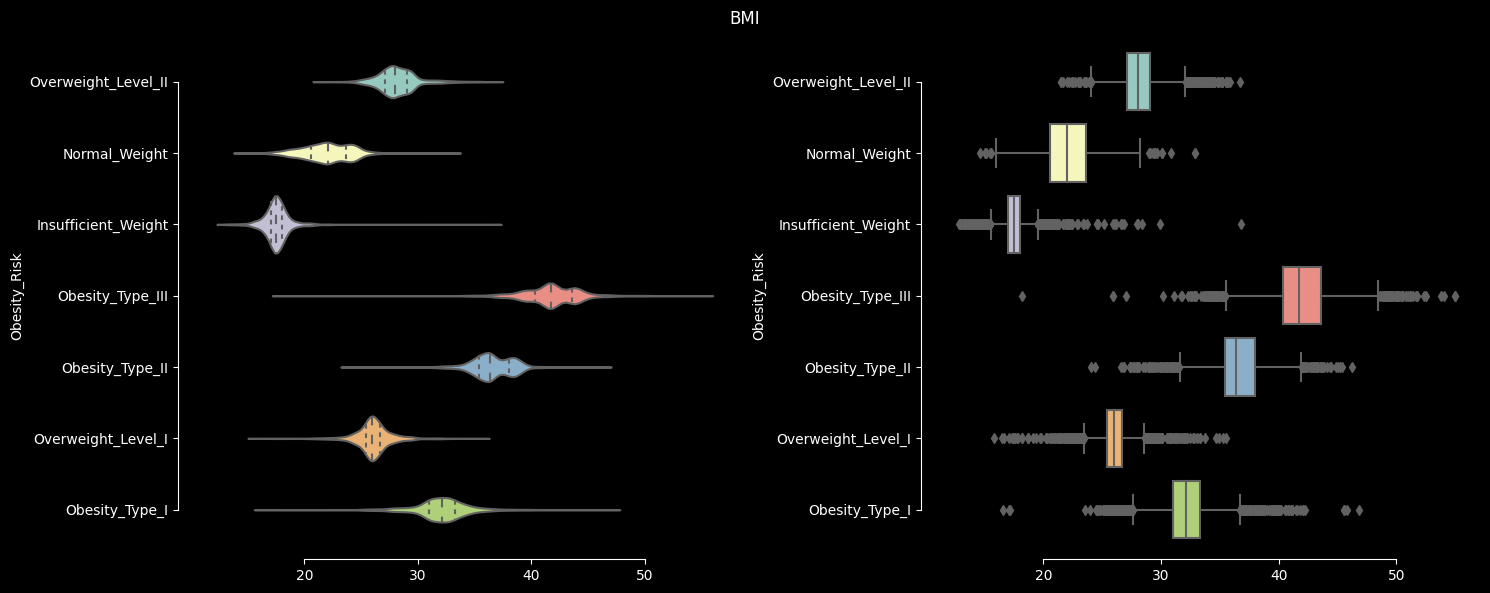

In [23]:
violins(train_copy, 'BMI', 'Obesity_Risk', None, style='dark_background')

In [24]:
train_copy.describe(include=['object'])

,Gender,Fam_history,Caloric_food,Foods_betwn_meals,Smoker,Calories_monitored,Alcohol_consume,Transport,Obesity_Risk
count,20758,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,17014,18982,17529,20513,20071,15066,16687,4046


In [25]:
def cross_hm(dataframe, cat_col1, cat_col2, cmap, style, fig_w=15, fig_h=6):
    plt.style.use(style)
    
    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h))
    figure.suptitle(f'{cat_col1} and {cat_col2}')
    
    cross_tab = pd.crosstab(dataframe[cat_col1], dataframe[cat_col2])
    fig_hm = sns.heatmap(cross_tab, annot=True, cmap=cmap, fmt='d', cbar=False, ax=axes)
#     plt.title(f'{cat_col1} and {cat_col2}')
    sns.despine(offset=10, trim=True)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

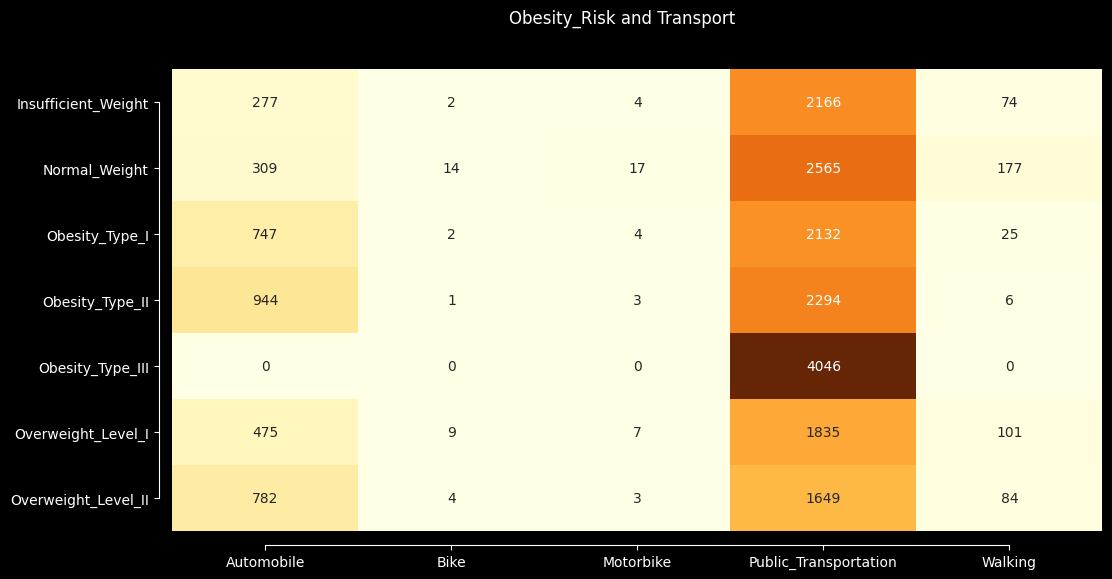

In [26]:
cross_hm(train_copy, 'Obesity_Risk', 'Transport', 'YlOrBr', 'dark_background', fig_w=12)

In [27]:
train_copy.groupby('Gender')['BMI'].mean().sort_values(ascending=False).index

Index(['Female', 'Male'], dtype='object', name='Gender')

In [28]:
def mean_dist_plot(dataframe, num_col, cat_col, fig_w=12, fig_h=6, style='dark_background', palette=None):
        
    plt.style.use(style)
    
    if palette:
        set_palette = palette
    else:
        set_palette = 'light:#4caba4_r'
    
    figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(fig_w, fig_h))
#     figure.suptitle(f'{cat_col1} and {cat_col2}')
    
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # df_train['BMI']=  df_train['Weight'] / df_train['Height']**2
#     ax1 = axes[0]
    df_sort = dataframe.groupby(cat_col)[num_col].mean().sort_values(ascending=False).index
    
    fig_bar = sns.barplot(data=train_copy,
                          x=num_col, 
                          y=cat_col, 
                          palette=set_palette, 
                          order=df_sort,
                          estimator=np.mean, 
                          ci=None, 
                          errwidth=0, 
                          ax=axes[0])
    
    for p in axes[0].patches:
        # print(p)
        axes[0].annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() + -.3),
                         ha='center', 
                         va='center', 
                         #xytext=(0, 50), 
                         textcoords='offset points', 
                         fontsize=10, 
                         color='black')
    
    axes[0].set_title(f'Mean {num_col} by {cat_col}')
    axes[0].set_xlabel(f'{num_col}')
    axes[0].set_ylabel('')
#     sns.despine(left=True, bottom=True, ax=ax1)
    sns.despine(offset=10, trim=True, ax=axes[0])
    # Violin Plot
#     ax2 = axes[1]
    fig_violin = sns.violinplot(data=dataframe,
                               x=num_col,
                               y=cat_col,
                               # hue=hue,
                               split=True, 
                               inner='quart',
                               fill=False,
                               palette=set_palette,
                               order=df_sort,
                               ax=axes[1])
    
    axes[1].set_title(f'Distribution of {num_col} by {cat_col}')
    axes[1].grid(False)
    axes[1].set_ylabel("")
    axes[1].set_xlabel(f"{num_col}")
    plt.yticks([])
    
    sns.despine(offset=10, trim=True, ax=axes[1])
    
    plt.tight_layout()
    plt.show()
#     fig_violin = sns.violinplot(data=train_copy,
#                                 x=num_col, y=cat_col,
#                                 palette='light:#4caba4_r',
#                                 order=df_sort, 
#                                 ax=axes[1])
    
#     ax2.set_title('Distribution of BMI by Gender')
#     ax2.set_ylabel("")
#     sns.despine(left=True, bottom=True, ax=ax2)

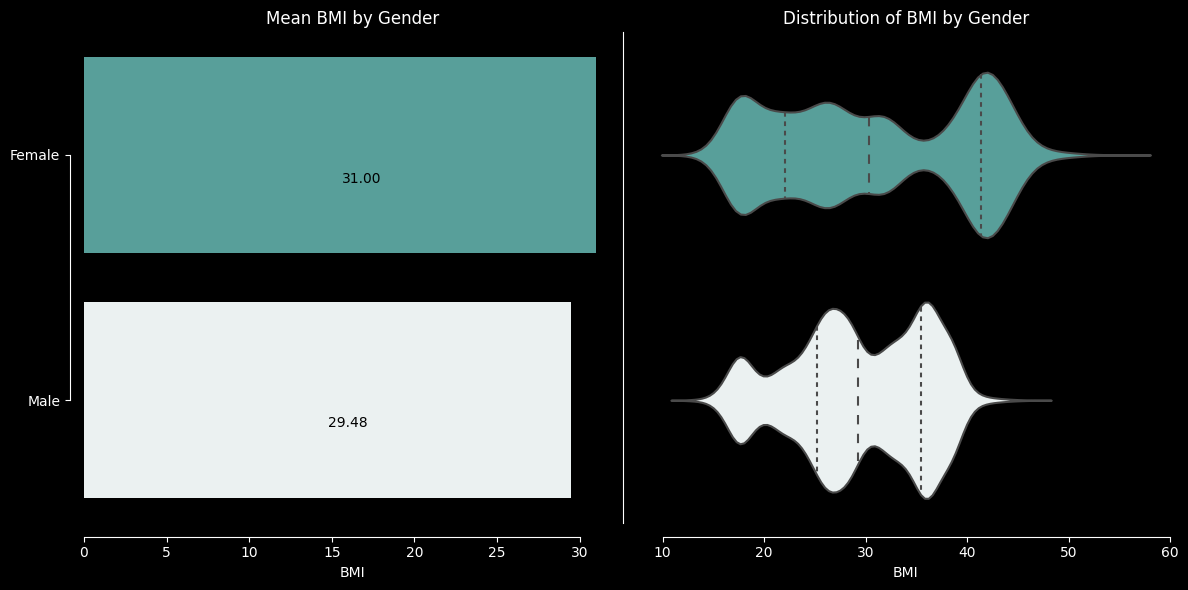

In [29]:
mean_dist_plot(train_copy, 'BMI', 'Gender')

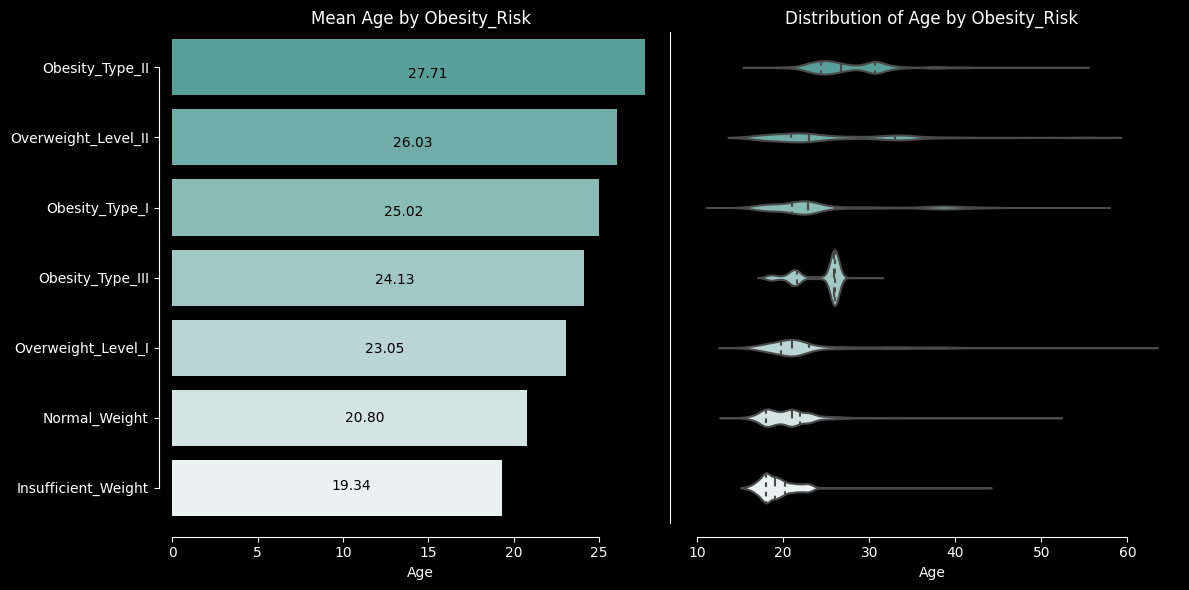

In [30]:
mean_dist_plot(train_copy, 'Age', 'Obesity_Risk')

In [31]:
# test_copy.head()
test_copy["BMI"] = test_copy['Weight']/(test_copy["Height"]**2)
test_copy.drop(["id","Height","Weight"],axis =1,inplace = True)

In [32]:
original_copy["BMI"] = original_copy['Weight']/(original_copy["Height"]**2)
original_copy.drop(["Height","Weight"],axis =1,inplace = True)

In [33]:
cat_cols = [ cols for cols in train_copy.columns if train_copy[cols].dtype == 'object' ]
num_cols = [ cols for cols in train_copy.columns if train_copy[cols].dtype != 'object' ]

**Current stated of the datasets**

In [34]:
#Let's check the samples of data
display('Train:', train_copy.sample(5))
display('Test:', test_copy.sample(5))
display('Original', original_copy.sample(5))

'Train:'

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,Physical_activity,Tech_addict,Alcohol_consume,Transport,Obesity_Risk,BMI
15814,Male,19.000000,yes,yes,3.000000,3.000000,Frequently,no,2.000000,no,3.0,0.000000,Sometimes,Public_Transportation,Overweight_Level_I,25.951557
456,Male,31.783524,yes,yes,2.948425,3.715148,Sometimes,no,1.781769,no,1.0,0.993786,Sometimes,Automobile,Overweight_Level_I,26.949107
11377,Male,21.000000,yes,yes,2.000000,3.000000,Sometimes,no,3.000000,no,1.0,0.000000,Sometimes,Public_Transportation,Obesity_Type_I,32.770513
12654,Male,18.000000,yes,yes,3.000000,3.000000,Sometimes,no,2.000000,no,2.0,1.000000,Sometimes,Public_Transportation,Normal_Weight,23.374726
9774,Male,20.000000,yes,yes,3.000000,3.000000,Sometimes,no,3.000000,no,2.0,1.000000,Sometimes,Public_Transportation,Overweight_Level_I,26.234568


'Test:'

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,Physical_activity,Tech_addict,Alcohol_consume,Transport,BMI
3926,Female,25.783865,yes,yes,3.000000,3.0,Sometimes,no,2.686824,no,0.01586,0.251150,Sometimes,Public_Transportation,40.482470
10420,Male,25.154620,yes,yes,2.191108,3.0,Sometimes,no,2.325091,no,1.17177,0.066805,Sometimes,Public_Transportation,37.833253
11572,Male,21.000000,yes,no,2.000000,3.0,Frequently,no,1.000000,no,2.00000,1.000000,Sometimes,Public_Transportation,25.951557
7545,Female,18.000000,yes,yes,3.000000,3.0,Always,no,2.000000,no,2.00000,2.000000,no,Public_Transportation,32.812500
5942,Male,22.000000,yes,yes,2.000000,4.0,Frequently,no,2.000000,no,3.00000,0.000000,Sometimes,Public_Transportation,24.772097


'Original'

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,Physical_activity,Tech_addict,Alcohol_consume,Transport,Obesity_Risk,BMI
1903,Female,19.137495,yes,yes,3.000000,3.000000,Sometimes,no,1.313834,no,0.912334,0.707494,Sometimes,Public_Transportation,Obesity_Type_III,43.320799
2028,Female,18.532826,yes,yes,3.000000,3.000000,Sometimes,no,2.372058,no,1.324805,0.870795,Sometimes,Public_Transportation,Obesity_Type_III,46.496996
572,Female,19.084967,no,yes,3.000000,3.725797,Sometimes,no,1.191401,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,15.859296
203,Male,29.000000,yes,no,2.000000,3.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Automobile,Obesity_Type_I,31.511502
1037,Male,18.701766,yes,yes,2.650629,1.000000,Sometimes,no,1.708083,no,1.876051,0.938791,Sometimes,Public_Transportation,Overweight_Level_II,27.998730


### 2.2.1 Outliers

In [35]:
def check_outliers(data, columns, dataframe):
    print(Text.BOLD_START + Text.BLUE + f"\nOutliers in {dataframe}:" + Text.BOLD_END)
    for column in columns:
        # Calculate IQR (Interquartile Range)
        iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
    
        # Define lower and upper thresholds
        lower_threshold = data[column].quantile(0.25) - 1.5 * iqr
        upper_threshold = data[column].quantile(0.75) + 1.5 * iqr
    
        # Find outliers
        outliers = data[(data[column] < lower_threshold) | (data[column] > upper_threshold)]
        
        if len(outliers) >0: # Print the count of outliers
            print(f"{column}: {len(outliers)}")

In [36]:
check_outliers(train_copy, num_cols,"Training_Data")
check_outliers(original_copy, num_cols,"Original_Data")
check_outliers(train_copy, num_cols,"Test_Data")


Outliers in Training_Data:
Age: 1074
Main_meals: 6052

Outliers in Original_Data:
Age: 168
Main_meals: 579

Outliers in Test_Data:
Age: 1074
Main_meals: 6052


In [37]:
train_copy["Age"].value_counts().sort_index()

Age
14.000000      5
15.000000      3
16.000000    109
16.093234      4
16.120699      1
            ... 
55.246250      2
55.272573      1
55.493687      1
56.000000      1
61.000000      2
Name: count, Length: 1703, dtype: int64

In [38]:
train_copy["Main_meals"].value_counts()

Main_meals
3.000000    14706
1.000000     1976
4.000000      715
2.993623       39
2.695396       25
            ...  
3.608850        1
1.193486        1
2.737620        1
3.019574        1
2.256119        1
Name: count, Length: 689, dtype: int64

### 2.2.2 check for consistency in categorical data between each dataframe

In [39]:
# trainign and test set
for columns in cat_cols[:-1]:    # create a list of the labels from those columns
    train_cols = sorted(list(train_copy[columns].value_counts().index))
    test_cols = sorted(list(test_copy[columns].value_counts().index))
    # ...if the values are not shared, then make note of this
    if test_cols != train_cols:
        print(f"{columns}")
        print(f'Training Data : {train_cols}')
        print(f'Test Data: {test_cols}')

Alcohol_consume
Training Data : ['Frequently', 'Sometimes', 'no']
Test Data: ['Always', 'Frequently', 'Sometimes', 'no']


In [40]:
# training and original data
for columns in cat_cols:    # create a list of the labels from those columns
    train_cols = sorted(list(train_copy[columns].value_counts().index))
    original_cols = sorted(list(original_copy[columns].value_counts().index))

    if original_cols != train_cols:
        print(f"{columns}")
        print(f'Training Data : {train_cols}')
        print(f'Original Data: {original_cols}')

Alcohol_consume
Training Data : ['Frequently', 'Sometimes', 'no']
Original Data: ['Always', 'Frequently', 'Sometimes', 'no']


### 2.2.3 Encoding

#### Label Encoding

In [41]:
target_labels = {
                  'Insufficient_Weight':0,
                  'Normal_Weight':1,
                  'Overweight_Level_I':2,
                  'Overweight_Level_II':3, 
                  'Obesity_Type_I':4,
                  'Obesity_Type_II':5 ,
                  'Obesity_Type_III':6
                  }

In [42]:
def encoding(data, tar):
    if 'Obesity_Risk' in data.columns:
        data['Obesity_Risk'] = data['Obesity_Risk'].map(tar)
    binary_cols = ['Gender','Fam_history', 'Caloric_food', 'Smoker','Calories_monitored']
    
    # Encode categorical variables using LabelEncoder
    data[binary_cols] = data[binary_cols].apply(LabelEncoder().fit_transform)

    return data

In [43]:
encoding(train_copy, target_labels)
encoding(test_copy, target_labels)
encoding(original_copy, target_labels)

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,Physical_activity,Tech_addict,Alcohol_consume,Transport,Obesity_Risk,BMI
0,0,21.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,0.000000,1.000000,no,Public_Transportation,1,24.386526
1,0,21.000000,1,0,3.0,3.0,Sometimes,1,3.000000,1,3.000000,0.000000,Sometimes,Public_Transportation,1,24.238227
2,1,23.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,2.000000,1.000000,Frequently,Public_Transportation,1,23.765432
3,1,27.000000,0,0,3.0,3.0,Sometimes,0,2.000000,0,2.000000,0.000000,Frequently,Walking,2,26.851852
4,1,22.000000,0,0,2.0,1.0,Sometimes,0,2.000000,0,0.000000,0.000000,Sometimes,Public_Transportation,3,28.342381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1,1,3.0,3.0,Sometimes,0,1.728139,0,1.676269,0.906247,Sometimes,Public_Transportation,6,44.901475
2107,0,21.982942,1,1,3.0,3.0,Sometimes,0,2.005130,0,1.341390,0.599270,Sometimes,Public_Transportation,6,43.741923
2108,0,22.524036,1,1,3.0,3.0,Sometimes,0,2.054193,0,1.414209,0.646288,Sometimes,Public_Transportation,6,43.543817
2109,0,24.361936,1,1,3.0,3.0,Sometimes,0,2.852339,0,1.139107,0.586035,Sometimes,Public_Transportation,6,44.071535


In [44]:
train_copy.head()
# test_copy.head()
# original_copy.head()

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,Physical_activity,Tech_addict,Alcohol_consume,Transport,Obesity_Risk,BMI
0,1,24.443011,1,1,2.000000,2.983297,Sometimes,0,2.763573,0,0.000000,0.976473,Sometimes,Public_Transportation,3,28.259565
1,0,18.000000,1,1,2.000000,3.000000,Frequently,0,2.000000,0,1.000000,1.000000,no,Automobile,1,23.422091
2,0,18.000000,1,1,1.880534,1.411685,Sometimes,0,1.910378,0,0.866045,1.673584,no,Public_Transportation,0,17.126706
3,0,20.952737,1,1,3.000000,3.000000,Sometimes,0,1.674061,0,1.467863,0.780199,Sometimes,Public_Transportation,6,44.855798
4,1,31.641081,1,1,2.679664,1.971472,Sometimes,0,1.979848,0,1.967973,0.931721,Sometimes,Public_Transportation,3,25.599151


#### Numerical Encoding

In [45]:
# Function to categorize age
def categorize_age(age):
    if age <= 18:
        return 'Teen'
    elif age <= 35:
        return 'Young_Adult'
    elif age <= 55:
        return 'Adult'
    else:
        return 'Senior'

def categorize_main_meals(main_meals):
    if main_meals <= 1.4:
        return 1
    elif main_meals <= 2.4:
        return 2
    elif main_meals <= 3.4:
        return 3
    else:
        return 4

def categorize_water_consume(water_consume):
    if water_consume <= 1.4:
        return 1
    elif water_consume <= 2.4:
        return 2
    else:
        return 3
    
def categorize_physical_activity(physical_activity):
    if physical_activity <= 0.4:
        return 0    
    elif physical_activity <= 1.4:
        return 1
    elif physical_activity <= 2.4:
        return 2
    else:
        return 3

def categorize_tech_addict(tech_addict):
    if tech_addict <= 0.4:
        return 0    
    elif tech_addict <= 1.4:
        return 1
    else:
        return 2
    
def categorize_veg(veg):
    if veg <= 1.4:
        return 0
    if veg <= 2.5:
        return 1
    else:
        return 2
    

In [46]:
# Age
train_copy['Age_Group'] = train_copy['Age'].apply(categorize_age)
test_copy['Age_Group'] = test_copy['Age'].apply(categorize_age)
original_copy['Age_Group'] = original_copy['Age'].apply(categorize_age)

# main meals
train_copy['#main_meals'] = train_copy['Main_meals'].apply(categorize_main_meals)
test_copy['#main_meals'] = test_copy['Main_meals'].apply(categorize_main_meals)
original_copy['#main_meals'] = original_copy['Main_meals'].apply(categorize_main_meals)

# water consumption
train_copy['water_consumption(L)'] = train_copy['Water_consume'].apply(categorize_water_consume)
test_copy['water_consumption(L)'] = test_copy['Water_consume'].apply(categorize_water_consume)
original_copy['water_consumption(L)'] = original_copy['Water_consume'].apply(categorize_water_consume)

# physical activity
train_copy['physical_act'] = train_copy['Physical_activity'].apply(categorize_physical_activity)
test_copy['physical_act'] = test_copy['Physical_activity'].apply(categorize_physical_activity)
original_copy['physical_act'] = original_copy['Physical_activity'].apply(categorize_physical_activity)

# tech addiction
train_copy['tech_addiction'] = train_copy['Tech_addict'].apply(categorize_tech_addict)
test_copy['tech_addiction'] = test_copy['Tech_addict'].apply(categorize_tech_addict)
original_copy['tech_addiction'] = original_copy['Tech_addict'].apply(categorize_tech_addict)

# Veg
train_copy['veg_category'] = train_copy['Veg'].apply(categorize_veg)
test_copy['veg_category'] = test_copy['Veg'].apply(categorize_veg)
original_copy['veg_category'] = original_copy['Veg'].apply(categorize_veg)

In [47]:
train_copy.sample(5)

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,...,Alcohol_consume,Transport,Obesity_Risk,BMI,Age_Group,#main_meals,water_consumption(L),physical_act,tech_addiction,veg_category
16521,0,21.001969,1,1,3.000000,3.0,Sometimes,0,1.657541,0,...,Sometimes,Public_Transportation,6,43.596137,Young_Adult,3,2,2,1,2
19163,1,25.539411,1,1,2.653721,3.0,Sometimes,0,2.010596,0,...,Sometimes,Public_Transportation,5,36.714604,Young_Adult,3,2,1,0,2
15017,0,25.955014,1,1,3.000000,3.0,Sometimes,0,2.094901,0,...,Sometimes,Public_Transportation,6,34.154290,Young_Adult,3,2,0,1,2
20116,1,30.899219,1,1,2.967300,3.0,Sometimes,0,2.530035,0,...,Sometimes,Automobile,5,38.994760,Young_Adult,3,3,1,1,2
5164,1,22.000000,0,1,3.000000,3.0,Frequently,0,3.000000,1,...,no,Motorbike,1,20.830703,Young_Adult,3,3,3,0,2


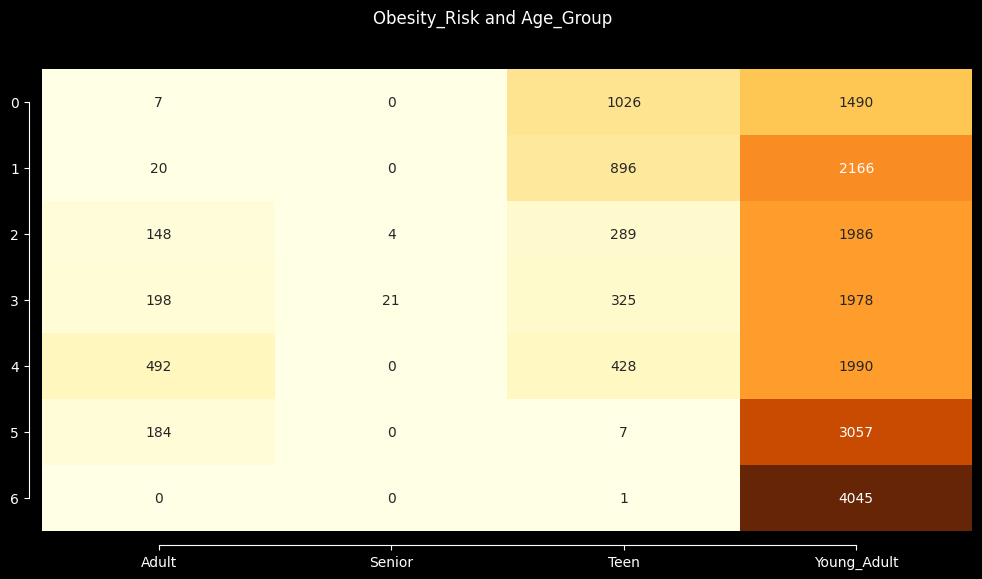

In [48]:
cross_hm(train_copy, 'Obesity_Risk', 'Age_Group', 'YlOrBr', 'dark_background', fig_w=12)

# Concat Data

In [49]:
concat_df = pd.concat([train_copy, original_copy], ignore_index=True)

In [50]:
concat_df

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,...,Alcohol_consume,Transport,Obesity_Risk,BMI,Age_Group,#main_meals,water_consumption(L),physical_act,tech_addiction,veg_category
0,1,24.443011,1,1,2.000000,2.983297,Sometimes,0,2.763573,0,...,Sometimes,Public_Transportation,3,28.259565,Young_Adult,3,3,0,1,1
1,0,18.000000,1,1,2.000000,3.000000,Frequently,0,2.000000,0,...,no,Automobile,1,23.422091,Teen,3,2,1,1,1
2,0,18.000000,1,1,1.880534,1.411685,Sometimes,0,1.910378,0,...,no,Public_Transportation,0,17.126706,Teen,2,2,1,2,1
3,0,20.952737,1,1,3.000000,3.000000,Sometimes,0,1.674061,0,...,Sometimes,Public_Transportation,6,44.855798,Young_Adult,3,2,2,1,2
4,1,31.641081,1,1,2.679664,1.971472,Sometimes,0,1.979848,0,...,Sometimes,Public_Transportation,3,25.599151,Young_Adult,2,2,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22864,0,20.976842,1,1,3.000000,3.000000,Sometimes,0,1.728139,0,...,Sometimes,Public_Transportation,6,44.901475,Young_Adult,3,2,2,1,2
22865,0,21.982942,1,1,3.000000,3.000000,Sometimes,0,2.005130,0,...,Sometimes,Public_Transportation,6,43.741923,Young_Adult,3,2,1,1,2
22866,0,22.524036,1,1,3.000000,3.000000,Sometimes,0,2.054193,0,...,Sometimes,Public_Transportation,6,43.543817,Young_Adult,3,2,2,1,2
22867,0,24.361936,1,1,3.000000,3.000000,Sometimes,0,2.852339,0,...,Sometimes,Public_Transportation,6,44.071535,Young_Adult,3,3,1,1,2


In [51]:
print(concat_df['Alcohol_consume'].unique())
print(concat_df['Alcohol_consume'].value_counts())

['Sometimes' 'no' 'Frequently' 'Always']
Alcohol_consume
Sometimes     16467
no             5802
Frequently      599
Always            1
Name: count, dtype: int64


In [52]:
test_copy['Alcohol_consume'].value_counts()

Alcohol_consume
Sometimes     9979
no            3513
Frequently     346
Always           2
Name: count, dtype: int64

## Dropping the 'Always' category from 'Alcohol Consume'

In [53]:
concat_df = concat_df.loc[~(concat_df['Alcohol_consume'] == 'Always')].reset_index(drop=True)
test_copy = test_copy.loc[~(test_copy['Alcohol_consume'] == 'Always')].reset_index(drop=True)

# Category encoding

In [54]:
print(concat_df['Foods_betwn_meals'].value_counts())
print(concat_df['Alcohol_consume'].value_counts())

Foods_betwn_meals
Sometimes     19294
Frequently     2713
Always          531
no              330
Name: count, dtype: int64
Alcohol_consume
Sometimes     16467
no             5802
Frequently      599
Name: count, dtype: int64


In [55]:
# food between meals mapping
fbm_mapping = {'no': 0,
               'Sometimes': 1,
               'Frequently': 2,
               'Always': 3
              }
# alcohol consume mapping

ac_mapping = {'no': 0,
              'Sometimes': 1,
              'Frequently': 2,
             }

# mapping age
age_mapping = {
    'Teen': 1,
    'Young_Adult': 2,
    'Adult': 3,
    'Senior': 4
}

def encode_categories(dataframe, col_name, mapping):

     
    dataframe[col_name] = dataframe[col_name].map(mapping)
    
    return dataframe
    

In [56]:
concat_df = encode_categories(concat_df, 'Foods_betwn_meals', fbm_mapping)
test_copy = encode_categories(test_copy, 'Foods_betwn_meals', fbm_mapping)

concat_df = encode_categories(concat_df, 'Alcohol_consume', ac_mapping)
test_copy = encode_categories(test_copy, 'Alcohol_consume', ac_mapping)

In [57]:
concat_df = encode_categories(concat_df, 'Age_Group', age_mapping)
test_copy = encode_categories(test_copy, 'Age_Group', age_mapping)

In [59]:
concat_df

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,...,Alcohol_consume,Transport,Obesity_Risk,BMI,Age_Group,#main_meals,water_consumption(L),physical_act,tech_addiction,veg_category
0,1,24.443011,1,1,2.000000,2.983297,1,0,2.763573,0,...,1,Public_Transportation,3,28.259565,2,3,3,0,1,1
1,0,18.000000,1,1,2.000000,3.000000,2,0,2.000000,0,...,0,Automobile,1,23.422091,1,3,2,1,1,1
2,0,18.000000,1,1,1.880534,1.411685,1,0,1.910378,0,...,0,Public_Transportation,0,17.126706,1,2,2,1,2,1
3,0,20.952737,1,1,3.000000,3.000000,1,0,1.674061,0,...,1,Public_Transportation,6,44.855798,2,3,2,2,1,2
4,1,31.641081,1,1,2.679664,1.971472,1,0,1.979848,0,...,1,Public_Transportation,3,25.599151,2,2,2,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22863,0,20.976842,1,1,3.000000,3.000000,1,0,1.728139,0,...,1,Public_Transportation,6,44.901475,2,3,2,2,1,2
22864,0,21.982942,1,1,3.000000,3.000000,1,0,2.005130,0,...,1,Public_Transportation,6,43.741923,2,3,2,1,1,2
22865,0,22.524036,1,1,3.000000,3.000000,1,0,2.054193,0,...,1,Public_Transportation,6,43.543817,2,3,2,2,1,2
22866,0,24.361936,1,1,3.000000,3.000000,1,0,2.852339,0,...,1,Public_Transportation,6,44.071535,2,3,3,1,1,2


#### One hot encoding

In [60]:
"""OHE = OneHotEncoder(categories='auto', 
                        drop='first', 
                        sparse=True, 
                        dtype=np.float64, 
                        handle_unknown='error')"""
ohe = OneHotEncoder(dtype=np.int16)

encoded = ohe.fit_transform(concat_df[['Transport']]).toarray()
ohe_df= pd.DataFrame(encoded, columns=ohe.get_feature_names_out())

In [61]:
concat_df = pd.concat([concat_df, ohe_df], axis=1)

In [62]:
concat_df.sample(15)

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,...,#main_meals,water_consumption(L),physical_act,tech_addiction,veg_category,Transport_Automobile,Transport_Bike,Transport_Motorbike,Transport_Public_Transportation,Transport_Walking
13458,1,23.096353,1,1,2.724285,3.000000,1,0,2.156870,0,...,3,2,1,0,2,0,0,0,1,0
21876,0,35.456326,1,1,2.156065,2.909117,1,0,1.221281,0,...,3,1,1,2,1,1,0,0,0,0
11674,1,22.927011,1,1,1.851262,1.890213,1,0,2.000000,0,...,2,2,1,0,1,0,0,0,1,0
4067,0,19.000000,1,1,3.000000,3.000000,1,0,2.000000,0,...,3,2,2,1,2,0,0,0,1,0
15077,0,20.000000,1,1,2.000000,1.000000,1,0,2.000000,0,...,1,2,0,1,1,0,0,0,1,0
895,1,23.000000,1,1,2.000000,3.000000,2,0,3.000000,1,...,3,3,3,0,1,0,0,0,1,0
12663,1,17.085250,1,1,2.869833,4.000000,1,0,2.000000,0,...,4,2,2,1,2,1,0,0,0,0
11483,1,30.754956,1,1,2.576490,3.000000,1,0,1.002292,0,...,3,1,2,0,2,1,0,0,0,0
8712,0,18.863875,0,1,2.866383,1.737620,1,0,1.099231,0,...,2,1,0,1,2,0,0,0,1,0
22155,0,22.847618,1,1,2.074843,1.773916,1,0,2.428271,0,...,2,3,0,1,1,0,0,0,1,0


In [63]:
print(concat_df.columns)

Index(['Gender', 'Age', 'Fam_history', 'Caloric_food', 'Veg', 'Main_meals',
       'Foods_betwn_meals', 'Smoker', 'Water_consume', 'Calories_monitored',
       'Physical_activity', 'Tech_addict', 'Alcohol_consume', 'Transport',
       'Obesity_Risk', 'BMI', 'Age_Group', '#main_meals',
       'water_consumption(L)', 'physical_act', 'tech_addiction',
       'veg_category', 'Transport_Automobile', 'Transport_Bike',
       'Transport_Motorbike', 'Transport_Public_Transportation',
       'Transport_Walking'],
      dtype='object')


## Rounding BMI

In [64]:
concat_df['BMI'] = np.round(concat_df['BMI'], 2)
test_copy['BMI'] = np.round(concat_df['BMI'], 2)

In [65]:
concat_df.sample(2)

,Gender,Age,Fam_history,Caloric_food,Veg,Main_meals,Foods_betwn_meals,Smoker,Water_consume,Calories_monitored,...,#main_meals,water_consumption(L),physical_act,tech_addiction,veg_category,Transport_Automobile,Transport_Bike,Transport_Motorbike,Transport_Public_Transportation,Transport_Walking
10273,0,28.0,1,1,3.0,1.0,2,0,1.000000,0,...,1,1,0,0,2,0,0,0,1,0
3789,0,26.0,1,1,3.0,3.0,1,0,2.682804,0,...,3,3,0,1,2,0,0,0,1,0


In [66]:
new_df = concat_df.drop(['Age','Main_meals','Water_consume','Physical_activity','Tech_addict','Veg','Transport'],axis = 1,inplace = False)

In [67]:
print(new_df.columns)

Index(['Gender', 'Fam_history', 'Caloric_food', 'Foods_betwn_meals', 'Smoker',
       'Calories_monitored', 'Alcohol_consume', 'Obesity_Risk', 'BMI',
       'Age_Group', '#main_meals', 'water_consumption(L)', 'physical_act',
       'tech_addiction', 'veg_category', 'Transport_Automobile',
       'Transport_Bike', 'Transport_Motorbike',
       'Transport_Public_Transportation', 'Transport_Walking'],
      dtype='object')


In [68]:
new_df

,Gender,Fam_history,Caloric_food,Foods_betwn_meals,Smoker,Calories_monitored,Alcohol_consume,Obesity_Risk,BMI,Age_Group,#main_meals,water_consumption(L),physical_act,tech_addiction,veg_category,Transport_Automobile,Transport_Bike,Transport_Motorbike,Transport_Public_Transportation,Transport_Walking
0,1,1,1,1,0,0,1,3,28.26,2,3,3,0,1,1,0,0,0,1,0
1,0,1,1,2,0,0,0,1,23.42,1,3,2,1,1,1,1,0,0,0,0
2,0,1,1,1,0,0,0,0,17.13,1,2,2,1,2,1,0,0,0,1,0
3,0,1,1,1,0,0,1,6,44.86,2,3,2,2,1,2,0,0,0,1,0
4,1,1,1,1,0,0,1,3,25.60,2,2,2,2,1,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22863,0,1,1,1,0,0,1,6,44.90,2,3,2,2,1,2,0,0,0,1,0
22864,0,1,1,1,0,0,1,6,43.74,2,3,2,1,1,2,0,0,0,1,0
22865,0,1,1,1,0,0,1,6,43.54,2,3,2,2,1,2,0,0,0,1,0
22866,0,1,1,1,0,0,1,6,44.07,2,3,3,1,1,2,0,0,0,1,0


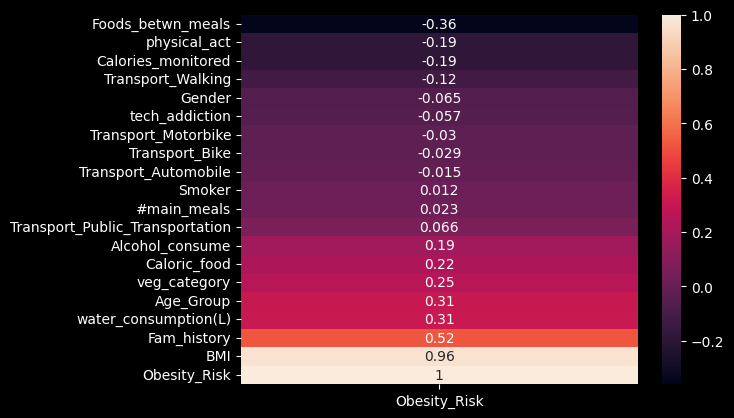

In [69]:
plt.style.use("dark_background")
corr = new_df.corr()[['Obesity_Risk']]
corr = corr.sort_values(by='Obesity_Risk')
sns.heatmap(corr, annot=True)
plt.show()

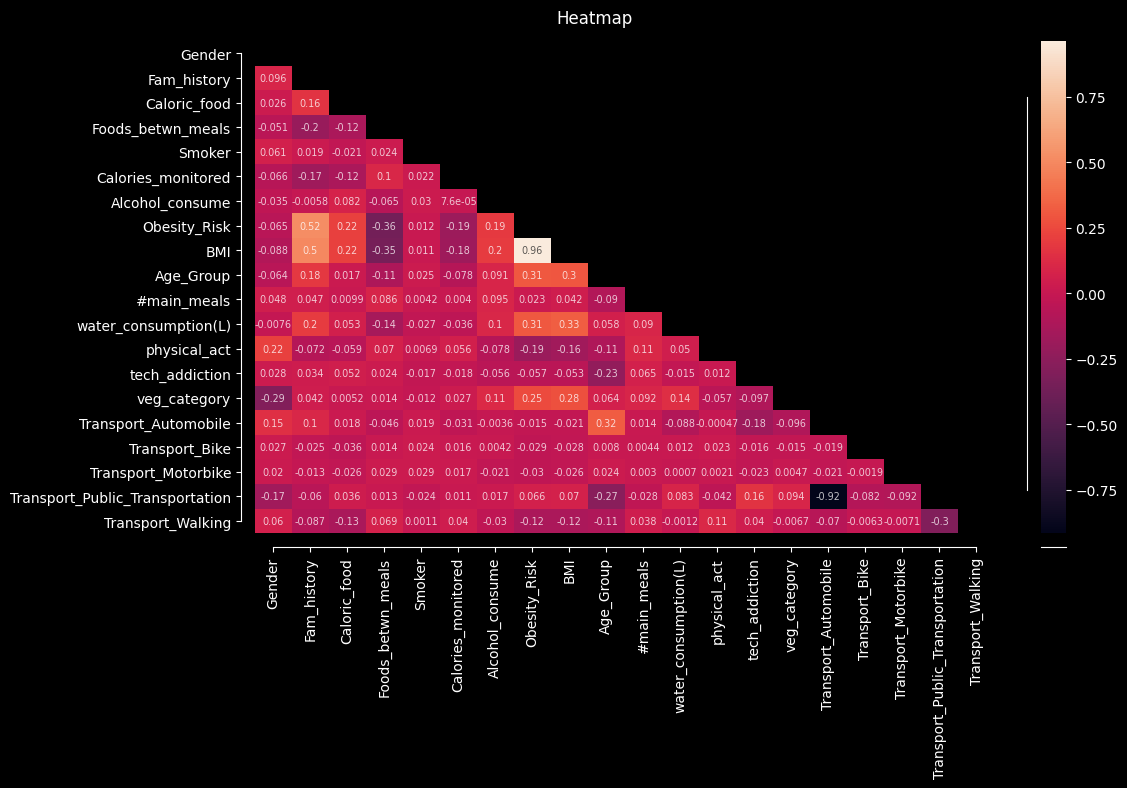

In [72]:
def tri_map(dataframe, cols_list, fig_w=12, fig_h=8, style="dark_background"):
     
    plt.style.use(style)
    
    figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h))
    
    figure.suptitle(f"Heatmap")
    
    corr = dataframe[cols_list].corr()

    # Getting the Upper Triangle of the co-relation matrix
    matrix = np.triu(corr)

    # using the upper triangle matrix as mask 
    fig_hm = sns.heatmap(corr, 
                         annot=True,
                         annot_kws={'size': 'x-small', 'alpha': 0.75},
                         mask=matrix, 
                         ax=axes)
    
    axes.tick_params(axis='x', labelrotation=90)
    
    sns.despine(offset=10, trim=True)
    
    plt.tight_layout()
    plt.show()
    
tri_map(new_df, new_df.columns)

In [74]:
new_df.drop_duplicates(ignore_index=True, inplace=True)

In [75]:
new_df.to_csv('obesity_risk_preprocessed.csv', index=False)